The purpose of this notebook is to provide a unified interface to our code for doing data generation.

We plan to do experiment with the following things:

**Circuit**

We will use circuits 1, 6, 9, and 14, as they cover a variety of circuit expressibilities and entangling capabilities.

| | High Ent | Low Ent |
| --- | --- | --- |
| High Exp|6 | 14 |
|Low Exp| 9 | 1 |

**Data sets**

We will use 4 data sets:

* Data set 0 (2 blobs, separable)
* Data set 1 (2 blobs, inseparable)
* Data set 2a (4 blobs, separable)
* Data set 3c (4 blobs) <-- Saesun's choice

**Learning rates**

We will investigate several learning rates.

----------------

The code below will help us set up our experiments.

In [2]:
# The code below is a hack in case Travis' kernel fails.
#import os
#os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
import sys
sys.path.append('../../Pyfiles')

# Pull in the helper files.
from experiments import *



In [4]:
# Set up the experiment
circuitID = 1
epochs = 20

In [6]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
lr_list=[round(((i+1)/10)**2,2) for i in range(20)]
ds_list=['0','1a','2a','3c']

for dsID in ds_list:
# Run the experiment
    print('--------dataset',dsID,'is initialized------')
    lr_acc=[]
    for lr in lr_list:
        # Load in the data
        data = load_data(dsID)

        # Generate the splittings
        train_X, train_y, validate_X, validate_y, test_X, test_y = generate_train_validate_test_data(data)

        # Make the feature map
        feature_map= make_embedding_circuit()

        # Make the classifier
        ansatz = make_classifer_circuit(circuitID)

        # Do the training
        model = train_model(feature_map, ansatz, epochs, lr, train_X, train_y)

        # Check the validation accuracy.
        val_accuracy = check_accuracy(model, validate_X, validate_y)

        lr_acc.append([lr,val_accuracy])
    np.savetxt(r"Learning_Rate_Data\circuit{0}_data{1}.txt".format(circuitID,dsID),lr_acc,fmt='%.2f')

--------dataset 0 is initialized------
__Learning Rate ( 0.01 ) is intialized
C:\Users\Saesun Kim\anaconda3\envs\qiskit\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
__Learning Rate ( 0.01 ) is done
__Learning Rate ( 0.04 ) is intialized


KeyboardInterrupt: 

In [7]:
# Set up the experiment
circuitID = 1
epochs = 20
ds_list=['0','1a','2a','3c']
#selected learning rates
lr_opt=[3.24,2.89,0.36,3.24]

In [7]:

model_list=[]
for i in range(4):
    data = load_data(ds_list[i])

    # Generate the splittings
    train_X, train_y, validate_X, validate_y, test_X, test_y = generate_train_validate_test_data(data)

    # Make the feature map
    feature_map= make_embedding_circuit()

    # Make the classifier
    ansatz = make_classifer_circuit(circuitID)

    # Do the training
    model = train_model(feature_map, ansatz, epochs, lr_opt[i], train_X, train_y)
    
    model_list.append(model)
    # Check the validation accuracy.
    val_accuracy = check_accuracy(model, test_X, test_y)

__Learning Rate ( 3.24 ) is intialized
C:\Users\Saesun Kim\anaconda3\envs\qiskit\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
__Learning Rate ( 3.24 ) is done
__Learning Rate ( 2.89 ) is intialized
__Learning Rate ( 2.89 ) is done
__Learning Rate ( 0.36 ) is intialized
__Learning Rate ( 0.36 ) is done
__Learning Rate ( 3.24 ) is intialized
__Learning Rate ( 3.24 ) is done


0.9009100101112234
0.5783619817997978
1.0
0.5762195121951219


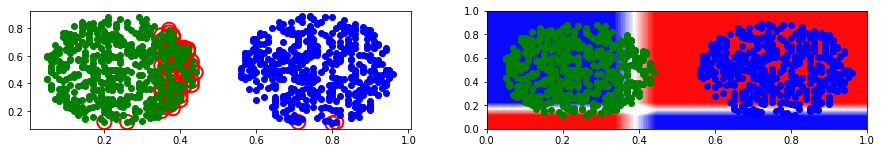

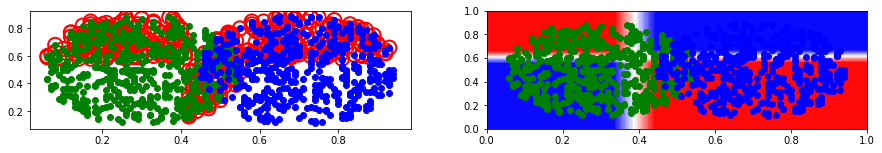

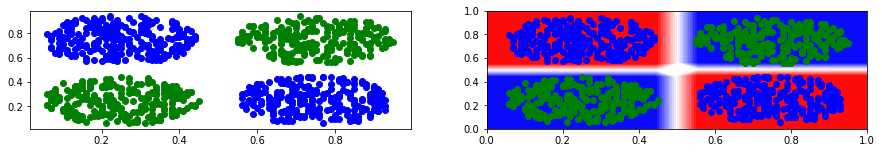

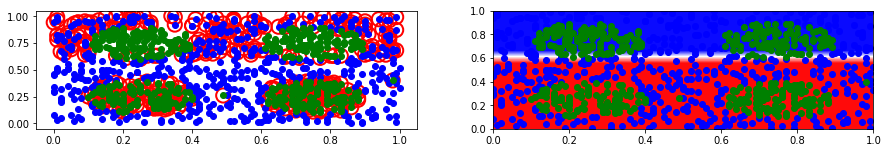

In [18]:
import matplotlib.pyplot as plt

for lr in range(4):


    data = load_data(ds_list[lr])

    # Generate the splittings
    train_X, train_y, validate_X, validate_y, test_X, test_y = generate_train_validate_test_data(data)

    fig = plt.figure(figsize=(15, 10))

    ax = fig.add_subplot(4, 2, 2*lr+1)
    y_predict = []
    for x in test_X:
        output = model_list[lr](Tensor(x))
        y_predict += [np.argmax(output.detach().numpy())]

    print(check_accuracy(model_list[lr], test_X, test_y))
    # plot results
    # red == wrongly classified
    for x, y_target, y_ in zip(test_X, test_y, y_predict):
        if y_target == 1:
            ax.plot(x[0], x[1], 'bo')
        else:
            ax.plot(x[0], x[1], 'go')
        if y_target != y_:
            ax.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)


    ax = fig.add_subplot(4, 2, 2*lr+2)
    for x, y_target, y_ in zip(test_X, test_y, y_predict):
        if y_target == 1:
            ax.plot(x[0], x[1], 'bo')
        else:
            ax.plot(x[0], x[1], 'go')

    X1 = np.linspace(0, 1, num=10)
    Z1 = np.zeros((len(X1), len(X1)))

    # Contour map
    for j in range(len(X1)):
        for k in range(len(X1)):
            # Fill Z with the labels (numerical values)
            # the inner loop goes over the columns of Z,
            # which corresponds to sweeping x-values
            # Therefore, the role of j,k is flipped in the signature
            Z1[j, k] = np.argmax(model_list[lr](Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())

    ax.contourf(X1, X1, Z1, cmap='bwr', levels=30)